In [11]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [13]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [14]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [15]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [16]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

Epoch 0 - Training loss: 0.651748804578077
Epoch 1 - Training loss: 0.28892765957107547
Epoch 2 - Training loss: 0.22653348961952272
Epoch 3 - Training loss: 0.1827875400728572
Epoch 4 - Training loss: 0.15335328905765755
Epoch 5 - Training loss: 0.13158748167028814
Epoch 6 - Training loss: 0.11484003261720607
Epoch 7 - Training loss: 0.10157897934091212
Epoch 8 - Training loss: 0.09125282517425827
Epoch 9 - Training loss: 0.0820878779064856
Epoch 10 - Training loss: 0.07542981066282338
Epoch 11 - Training loss: 0.06909570080051416
Epoch 12 - Training loss: 0.0637955805053438
Epoch 13 - Training loss: 0.058612317640159624
Epoch 14 - Training loss: 0.05447040941329923

Training Time (in minutes) = 5.040839966138204


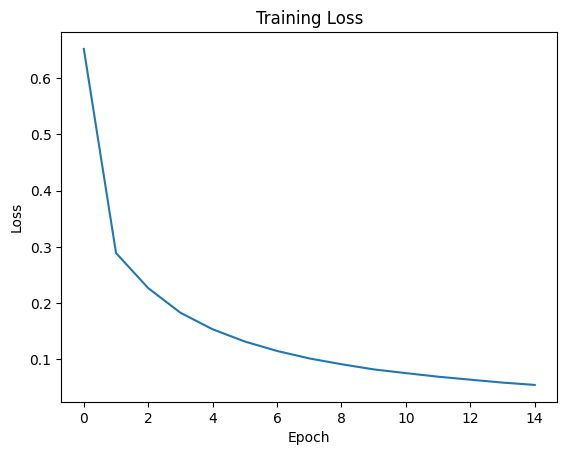

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
loss_values = []
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        #output = model(images.cuda())
        loss = criterion(output, labels)
        #loss = criterion(output, labels.cuda())

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        epoch_loss = running_loss / len(trainloader)
        loss_values.append(epoch_loss)
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [18]:
# Taken from https://github.com/amitrajitbose/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_GPU.ipynb
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()
    #ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 0


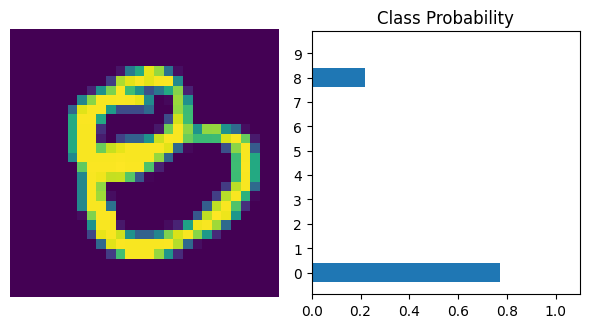

In [19]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Number Of Images Tested = 10000

Model Accuracy = 0.9724


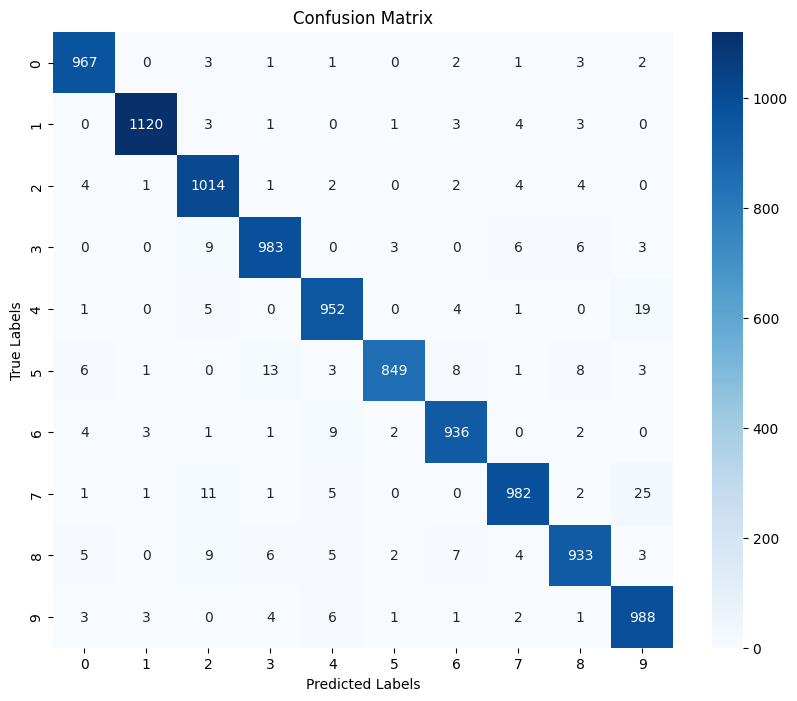

In [20]:
correct_count, all_count = 0, 0
true_labels = []
pred_labels = []

for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]

    true_labels.append(true_label)
    pred_labels.append(pred_label)

    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [21]:
torch.save(model, './my_mnist_model.pt')

In [22]:
# Tutorial references
# https://github.com/amitrajitbose/handwritten-digit-recognition/blob/master/handwritten_digit_recognition_GPU.ipynb
# https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627